In [162]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [3]:
#1.calibrate your camera and undistort,
calibration_images = glob.glob('camera_cal/calibration*.jpg')
nx = 9
ny = 6
objpoints = []
imgpoints = []
gray_shape = None
for fname in calibration_images:
    calibration = mpimg.imread(fname)
    gray = cv2.cvtColor(calibration, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret == True:
        imgpoints.append(corners)
        objp = np.zeros((ny * nx, 3), np.float32)
        gray_shape = gray.shape[::-1]
        # z stays zero, x and y cordinates turns to point index
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
        objpoints.append(objp)
    else:
        print('not found corners',fname)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_shape, None, None)

not found corners camera_cal/calibration1.jpg
not found corners camera_cal/calibration4.jpg
not found corners camera_cal/calibration5.jpg


(720, 1280, 3)


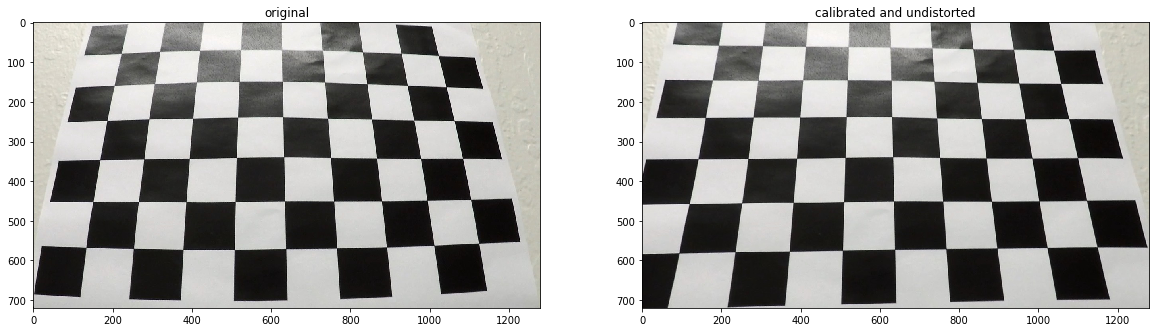

In [4]:
# test function
test_image = mpimg.imread('camera_cal/calibration3.jpg')
dst = cv2.undistort(test_image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('original')
ax1.imshow(test_image)

ax2.imshow(dst)
ax2.set_title('calibrated and undistorted')
cv2.imwrite('output_images/calibration3_undistort.jpg', dst)
print(dst.shape)

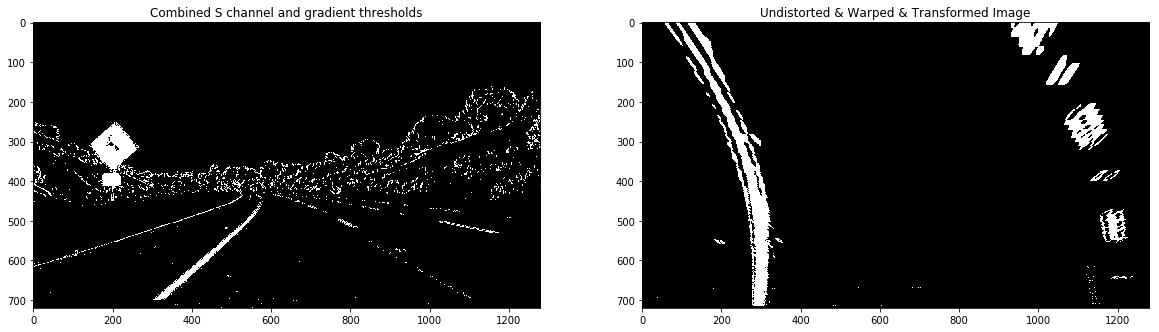

In [175]:
#undistort an test image, 
def undistort_threshold_image(test_image, show_output = False):
    undistort_test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
    #apply thresholds to create a binary image 
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(undistort_test_image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(undistort_test_image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    thresh_min = 30 
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    #perform perspective transform
    height, width = combined_binary.shape
    y_boundary = 450
    x_top_left = 565
    x_top_right = 695#685
    x_bottom_left = 0 
    x_bottom_right = width 
    mask_vertices = [[x_bottom_left,height],[x_top_left,y_boundary], [x_top_right,y_boundary],[x_bottom_right,height]]
    mask_vertices_array = np.array([[(x_bottom_left,height),(x_top_left,y_boundary), (x_top_right,y_boundary), (x_bottom_right,height)]], dtype=np.int32)
    
    #apply a perspective transform.
    transform_src = np.float32(mask_vertices)
    transform_dst = np.float32([[0,height],[0,0],[width,0],[width,height]])
    
    M = cv2.getPerspectiveTransform(transform_src, transform_dst)
    binary_warped = cv2.warpPerspective(combined_binary, M, (width,height), flags=cv2.INTER_LINEAR)

    if show_output:
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Combined S channel and gradient thresholds')
        ax1.imshow(combined_binary, cmap='gray')
        cv2.imwrite('output_images/thresholded_binary.jpg', combined_binary * 255)
        ax2.imshow(binary_warped, cmap='gray')
        cv2.imwrite('output_images/unwarped_transformed_binary.jpg', binary_warped * 255)
        ax2.set_title('Undistorted & Warped & Transformed Image')
    binary_warped.dtype='uint8'
    return binary_warped, undistort_test_image, M, height, width, mask_vertices_array


test_image = mpimg.imread('test_images/test2.jpg')#test1.jpg')image_in_video.jpg straight_lines1.jpg
binary_warped, undistort_test_image, M, height, width, mask_vertices_array = undistort_threshold_image(test_image,True)
# masked_region_image = region_of_interest(undistort_test_image, mask_vertices_array)
# plt.imshow(masked_region_image)

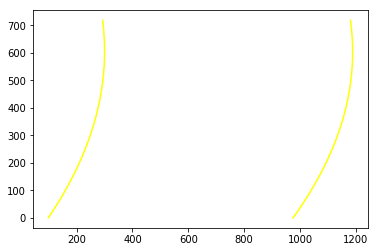

In [176]:
#locate lane lines
def find_lane_pixels(binary_warped, draw_windows = False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if draw_windows:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, draw = False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, draw)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
   
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    if draw:
    # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    left_pts = np.array([[[xi, yi]] for xi, yi in zip(left_fitx, ploty) ]).astype(np.int32)
    right_pts = np.array([[[xi, yi]] for xi, yi in zip(right_fitx, ploty) ]).astype(np.int32)
    right_pts = np.flipud(right_pts)
    points = np.concatenate((left_pts, right_pts))
    cv2.fillPoly(out_img, [points], color=[0,255,0])
    return out_img, left_fit,  right_fit, ploty

out_img,  left_fit,  right_fit, ploty = fit_polynomial(binary_warped, True)

True

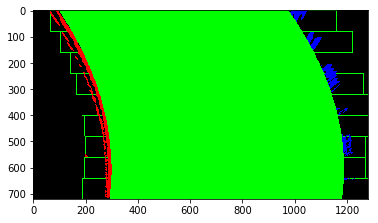

In [177]:
plt.imshow(out_img)  #
cv2.imwrite('output_images/perspective_view_with_lanes.jpg', out_img)

In [183]:
def measure_curvature_pixels( left_fit_cr,  right_fit_cr, ploty):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # use 30m here because there are almost 3 dashed lines, so 30 is reasonable here
    ym_per_pix = 30/720 # meters per pixel in y dimension
    # use 920 pix here because it is the width from output image above
    xm_per_pix = 3.7/920 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return int(left_curverad), int(right_curverad)
def measure_offset(width, left_fit, right_fit):
    left_lane_position = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    right_lane_position = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    lane_center = (right_lane_position - left_lane_position)/2
    xm_per_pix = 3.7/920
    offset = (lane_center - width/2 ) * xm_per_pix
    return "Vehicle is %f(m) %s of center " % (abs(offset), 'left' if offset < 0 else 'right')
    

# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(left_fit,  right_fit, ploty)
measure_offset(height, left_fit, right_fit)
print(left_curverad, right_curverad)
print(width)

1508 1493
1280


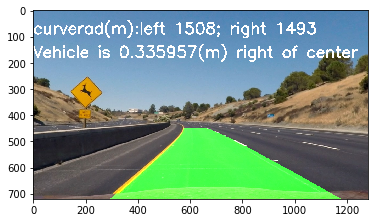

In [179]:
def process_image(image, show = False, cnt =1):
    binary_warped, undistort_test_image, M, height, width, mask_vertices_array = undistort_threshold_image(image)
    out_img, left_fit,  right_fit, ploty = fit_polynomial(binary_warped)
    # map polyfit to original image
    inverted_binary_warped = cv2.warpPerspective(out_img, M, (width,height), flags=cv2.WARP_INVERSE_MAP)
    stacked_out_image = np.dstack(( undistort_test_image[:,:,0], np.maximum(undistort_test_image[:,:,1], inverted_binary_warped[:,:,1]),undistort_test_image[:,:,2]))
    left_curverad, right_curverad = measure_curvature_pixels(left_fit,  right_fit, ploty)

    curv_text = "curverad(m):left %d; right %d" % (left_curverad, right_curverad)
    offset_text = measure_offset(height, left_fit, right_fit)
    cv2.putText(stacked_out_image, curv_text, (0, int(height/8)), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 255, 255), thickness =5)
    cv2.putText(stacked_out_image, offset_text, (0, int(height/4)), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (255, 255, 255), thickness =5)
    if show:
        plt.imshow(stacked_out_image)
        cv2.imwrite('output_images/camera_view_with_lanes.jpg', stacked_out_image)
    return stacked_out_image
test_image = mpimg.imread('test_images/test2.jpg')
final_out_image = process_image(test_image, True)

In [182]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#apply to video
video_name = 'project_video.mp4'

white_output = 'test_videos_output/'+ video_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [05:16<00:00,  3.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 2min 53s, sys: 14.8 s, total: 3min 8s
Wall time: 5min 19s


In [184]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))